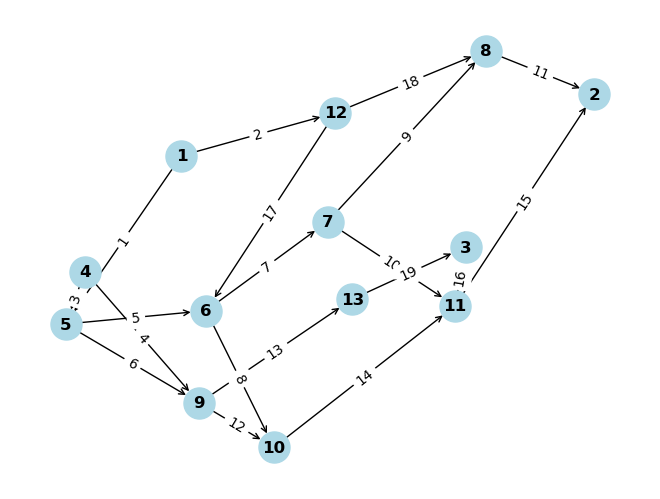

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_network():
    # 创建一个有向图
    G = nx.DiGraph()

    # 添加节点
    nodes = range(1, 14)
    G.add_nodes_from(nodes)

    # 添加有向边
    edges = [(1, 5), (1, 12), (4, 5), (4, 9), (5, 6), (5, 9), (6, 7), (6, 10),
             (7, 8), (7, 11), (8, 2), (9, 10), (9, 13), (10, 11), (11, 2),
             (11, 3), (12, 6), (12, 8), (13, 3)]
    G.add_edges_from(edges)

    # 设置节点属性
    node_labels = {node: str(node) for node in G.nodes}
    nx.set_node_attributes(G, node_labels, 'label')

    # 设置边属性
    edge_labels = {(edge[0], edge[1]): i for i, edge in enumerate(edges, 1)}
    nx.set_edge_attributes(G, edge_labels, 'label')

    # 绘制图形
    pos = nx.spring_layout(G)  # 指定节点位置布局
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, arrowstyle='->', arrowsize=10,
            font_size=12, font_weight='bold')

    # 添加边标签
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # 显示图形
    # plt.show()

    return G

def get_upstream(G, edge_label):
    upstream_edges = set()
    for edge in G.in_edges():
        if G.edges[edge]['label'] == edge_label:
            start_node = edge[0]
            upstream_edges.update(G.edges[edge]['label'] for edge in G.in_edges(start_node))

    if not upstream_edges:
        upstream_edges = [-1]  # 用一个无效值替代空集合  
              
    return upstream_edges

def get_downstream(G, edge_label):
    downstream_edges = set()
    for edge in G.out_edges():
        if G.edges[edge]['label'] == edge_label:
            end_node = edge[1]
            downstream_edges.update(G.edges[edge]['label'] for edge in G.out_edges(end_node))
    
    if not downstream_edges:
        downstream_edges = [-1]  # 用一个无效值替代空集合
    
    return downstream_edges

# 生成网络
grid_graph = generate_network()

#测试 get_upstream() 方法
# edge_label = 2
# upstream_edges = get_upstream(grid_graph, edge_label)
# print(f"Upstream edges of edge {edge_label}: {upstream_edges}")

#测试 get_downstream() 方法
# edge_label = 16
# downstream_edges = get_downstream(grid_graph, edge_label)
# print(f"Downstream edges of edge {edge_label}: {downstream_edges}")

In [32]:
import gurobipy as gp
from gurobipy import GRB
import random

# 设置随机种子
random.seed(123)

# 创建模型
model = gp.Model("mip1")

# 定义参数N和M的值
N = 19  # 边的编号
M = 5   # 时间的编号
K = 1
M_range = range(1,M+1)
N_range = range(1,N+1)
K_range = range(1,K+1)
time_span = 2 #事故持续时间
# 创建二维变量矩阵P，并初始化为0
P = {}
P_initial = {}  # 用于保存P的初始值
for i in M_range:
    for j in N_range:
        P[i, j] = 0


origin_time_index = 1  # 事故发生时间
origin_link_index = 7  # 事故发生link

P[origin_time_index, origin_link_index] = 1

for i in range((origin_time_index + 1),(origin_time_index + 2 + time_span)):
    for j in get_upstream(grid_graph, origin_link_index):
        P[i, j] = 1

for i in range(origin_time_index,origin_time_index + time_span + 1):
    for j in range(origin_link_index,origin_link_index+1):
        P[i, j] = 1


for i in range((origin_time_index + 2),(origin_time_index + 3 + time_span)):
    for j in get_upstream(grid_graph, 5):
        P[i, j] = 1

for i in range((origin_time_index + 2),(origin_time_index + 3 + time_span)):
    for j in get_upstream(grid_graph, 17):
        P[i, j] = 1

for i in range(origin_time_index,origin_time_index + time_span + 1):
    for j in range(origin_link_index,origin_link_index+1):
        P[i, j] = 1


# 将所有变量添加到模型中




# 随机选择noise个需要转换的值的索引
noise = 5
indices = []
while len(indices) < noise:
    index = random.choice(list(P.keys()))
    if index not in indices:
        indices.append(index)

#对选定的索引进行值的转换
# for index in indices:
#     P[index].setAttr(GRB.Attr.Start, 1 - P[index].getAttr(GRB.Attr.Start))

for i in M_range:
    for j in N_range:
        P_initial[i, j] = model.addVar(vtype=GRB.BINARY, name=f"P_initial[{i},{j}]")
        P_initial[i, j].LB = float(P[i, j])
        P_initial[i, j].UB = float(P[i, j])



model.update()
#调试p_value
# model.optimize()
#
# P_values = model.getAttr('X', P)
#
# for i in M_range:
#     for j in N_range:
#         print(f"P[{i},{j}] = {P_values[i,j]}")



In [33]:
# 创建决策变量
gamma  = model.addVars(K_range,M_range,N_range,vtype=GRB.BINARY, name="gamma") #link n在时间区间m上确实受到了事故k影响则为1
delta  = model.addVars(K_range,M_range,N_range,vtype=GRB.BINARY, name="delta") #事故k起源于在时间区间m上的link n则为1
lambda1 = model.addVar(vtype=gp.GRB.BINARY, name="lambda1")
lambda2 = model.addVar(vtype=gp.GRB.BINARY, name="lambda2")
lambda3 = model.addVar(vtype=gp.GRB.BINARY, name="lambda3")
lambda4 = model.addVar(vtype=gp.GRB.BINARY, name="lambda4")
lambda5 = model.addVar(vtype=gp.GRB.BINARY, name="lambda5")
lambda6 = model.addVar(vtype=gp.GRB.BINARY, name="lambda6")


def get_delta_value(k,m,n):
    if k in K_range and m in M_range and n in N_range:
        return delta[k,m,n]
    else:
        return 0

In [34]:
# 求解模型
# model.optimize()

# # 获取P的取值
# P_values = m.getAttr('X', P)

# # 打印P的取值
# for i in N_range:
#     for j in M_range:
#         print(f"P[{i},{j}] = {P_values[i,j]}")

    

# # 获取delta的取值
# delta_values = m.getAttr('X', delta)

# # 打印delta的取值
# for k in K_range:
#     for m in M_range:
#         for n in N_range:
#             print(f"delta[{k},{m},{n}] = {delta_values[k,m,n]}")    

In [35]:
#目标函数
model.setObjective(gp.quicksum(P_initial[m,n]*(1-gp.quicksum(delta[k,m,n]for k in K_range))+(1-P_initial[m,n])*gp.quicksum(delta[k,m,n]for k in K_range)for m in M_range for n in N_range), GRB.MINIMIZE)


In [36]:
# for k in K_range:
#     for m in M_range:
#         for n in N_range:
#             if k in K_range and m in M_range and n in N_range:
#                 model.addConstr(gp.quicksum(get_delta_value(k,m,l) for l in get_downstream(grid_graph, n)) +get_delta_value(k,m-1,n) >= delta[k,m,n] - gamma[k,m,n], name="c1")

In [37]:
model.addConstr(delta[1, 3, 17] == 1)
# model.addConstr(gamma[1, 1, 7] == 1)

<gurobi.Constr *Awaiting Model Update*>

In [38]:
#约束1-2 保证冲击波的定向传播
#约束1：如果cell<m,n>受到了事故影响，且不是起源cell，那么该影响势必源自下游link或前一时刻或二者兼具
model.addConstrs((gp.quicksum(get_delta_value(k,m,l)for l in get_downstream(grid_graph, n))+get_delta_value(k,m-1,n) >= delta[k,m,n]-gamma[k,m,n] for k in K_range for m in M_range for n in N_range), "c1")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [39]:
#约束3-6 保证冲击波的不间断传播
#约束3：
model.addConstrs((get_delta_value(k,m-1,n)<=lambda1 for k in K_range for m in M_range for n in N_range),"c3")
#约束4：
model.addConstrs((gp.quicksum(get_delta_value(k,m,l)for l in get_downstream(grid_graph, n))<=lambda2*len(get_downstream(grid_graph, n)) for k in K_range for m in M_range for n in N_range), "c4")
#约束5:
model.addConstrs((delta[k,m,n]>=1-lambda3 for k in K_range for m in M_range for n in N_range),"c5")
#约束6:
model.addConstr((lambda1+lambda2+lambda3<=2),"c6")

<gurobi.Constr *Awaiting Model Update*>